In [54]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as impg

%matplotlib inline

In [82]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #distance between the lane and left of image
        self.lane_x_zero = None

In [56]:
def calibrate_camera(images, nx = 9, ny = 6):
    '''
    Find require parameters to calibrate camera with chessboard images
    param: 
        images: recommending at least 20 images
        nx: number of corners each row
        ny: number of corners each column
    return:
        mtx: camera matrix
        dist: distortion coeficients
    '''
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    objpoints = []
    imgpoints = []
    for img_path in camera_cal_img_paths:
        img = plt.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            #plt.imshow(img)
            objpoints.append(objp)
            imgpoints.append(corners)
            
    # camera calibration
    ret, mtx, dist, rvess, tvess = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx, dist)


def threshold_sx_s(image, sx_thres = [20, 100], s_thres = [120, 255]):
    '''
    Saturation and gradient of lightness on x direction thresholding the image and generate a binary image
    param:
        image: a image, require color space is RGB
        sx_thres: a list, [lower_bound, higher_bound] threshold for scaled sobel x
        s_thres: a list, [lower_bound, higher_bound] threshold for saturation channel
    return:
        a binary image after applying both thresholding 
    '''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    sxbinary = np.zeros_like(l_channel)
    sxbinary[(scaled_sobel >= sx_thres[0]) & (scaled_sobel < sx_thres[1])] = 1
    
    s_binary = np.zeros_like(l_channel)
    s_binary[(s_channel >= s_thres[0]) & (s_channel < s_thres[1])] = 1
    
    combined_binary = np.zeros_like(l_channel)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    return combined_binary


def perspective_transform(src, dest):
    '''
    Find both transform matrix and inverse transform matrix with provided srt and dest
    '''
    M = cv2.getPerspectiveTransform(src, dest)
    M_inv = cv2.getPerspectiveTransform(dest, src)
    return (M, M_inv)

In [57]:
def blind_search(side, binary_warped, nwindows = 9, margin = 75, minpix = 100):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    if side == 'left':
        x_base = np.argmax(histogram[:midpoint])
    else:
        x_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    x_current = x_base
    
    # Create empty lists to receive left and right lane pixel indices
    lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
 
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]

        
        # Append these indices to the lists
        lane_inds.append(good_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > minpix:
            x_current = np.int(np.mean(nonzerox[good_inds]))

    # Concatenate the arrays of indices
    lane_inds = np.concatenate(lane_inds)
    
    # Extract left and right line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 

    # Fit a second order polynomial to each
    fit = np.polyfit(y, x, 2)
    
    if side == 'left':
        left_lane.detected = True
        left_lane.allx = x
        left_lane.ally = y
        left_lane.current_fit = fit
    else:
        right_lane.detected = True
        right_lane.allx = x
        right_lane.ally = y
        right_lane.current_fit = fit
    

In [58]:
def margin_search(side, binary_warped, nwindows = 9, margin = 75, minpix = 100):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
 
    if side == 'left':
        fit = left_lane.current_fit
    else:
        fit = right_lane.current_fit
        
    lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + 
    fit[2] - margin)) & (nonzerox < (fit[0]*(nonzeroy**2) + 
    fit[1]*nonzeroy + fit[2] + margin))) 

    # Again, extract left and right line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 

    # Fit a second order polynomial to each
    fit = np.polyfit(y, x, 2)
    
    if side == 'left':
        left_lane.allx = x
        left_lane.ally = y
        left_lane.current_fit = fit
    else:
        right_lane.allx = x
        right_lane.ally = y
        right_lane.current_fit = fit
    

In [59]:
def findLanes(binary_warped, nwindows = 9, margin = 75, minpix = 100):
    
    if not left_lane.detected:
        blind_search('left', binary_warped, nwindows, margin, minpix)
    else:
        margin_search('left', binary_warped, nwindows, margin, minpix)
    
    if not right_lane.detected:
        blind_search('right', binary_warped, nwindows, margin, minpix)
    else:
        margin_search('right', binary_warped, nwindows, margin, minpix)
    

In [60]:
def projectLane(image, M_inv):
    
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

In [88]:
def cal_curvature(side, y_eval, h = 20, ym_per_pix = 30/720, xm_per_pix = 3.7/800):
    
    if side == 'left':
        x, y = left_lane.allx, left_lane.ally
    else:
        x, y = right_lane.allx, right_lane.ally
        
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    lane_x_zero = fit_cr[0] * h**2 + fit_cr[1] * h + fit_cr[2]
    
    if side == 'left':
        left_lane.lane_x_zero = lane_x_zero
        left_lane.radius_of_curvature = curverad
    else:
        right_lane.lane_x_zero = lane_x_zero
        right_lane.radius_of_curvature = curverad
        

In [92]:
def add_desc(new_image, num_pix_x, xm_per_pix = 3.7/800):
    
    lane_center = (right_lane.lane_x_zero - left_lane.lane_x_zero)
    vehicle_center = (num_pix_x * xm_per_pix) / 2
    
    to_left = lane_center - vehicle_center
    text1 = 'Radius of curvature: {0:.0f}(m)'.format(
    (left_lane.radius_of_curvature + right_lane.radius_of_curvature) / 2)
    
    text2 = 'Vehicle is {:.3f} m left to the center'.format(to_left)
    result = new_image.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text1, (100,100), font, 1, (255,255,255),2, cv2.LINE_AA)
    cv2.putText(result, text2, (100,150), font, 1,(255,255,255), 2, cv2.LINE_AA)
    
    return result

In [90]:
def process_image(image):
    
    undist = cv2.undistort(image,
                           mtx,
                           dst,
                           None, 
                           mtx)
    binary_warped = threshold_sx_s(undist)
    warped = cv2.warpPerspective(binary_warped, 
                                 M, 
                                 binary_warped.shape[::-1], 
                                 flags = cv2.INTER_LINEAR)
    
    findLanes(warped)

    new_image= projectLane(undist, 
                           M_inv)
    
    cal_curvature('left', new_image.shape[0])
    cal_curvature('right', new_image.shape[0])
    
    new_image = add_desc(new_image, new_image.shape[1])
    
    return new_image

In [63]:
camera_cal_img_paths = list(map(lambda path: './camera_cal/' + path.split('\\')[-1] ,
                     glob.glob('./camera_cal/*.jpg')))
camera_cal_imgs = [plt.imread(img_path) for img_path in camera_cal_img_paths]


In [64]:
test_img_paths = list(map(lambda path: './test_images/' + path.split('\\')[-1],
                          glob.glob('./test_images/*.jpg')))
test_imgs = [plt.imread(img_path) for img_path in test_img_paths]

In [65]:
mtx, dst = calibrate_camera(camera_cal_imgs, 9, 6)

In [66]:
src = np.float32([[570, 467],
                  [206, 720], 
                  [715, 467],
                  [1100, 720]])
dest = np.float32([[325, 200],
                   [325, 720],
                   [968, 200],
                   [968, 720]])

M, M_inv = perspective_transform(src, dest)

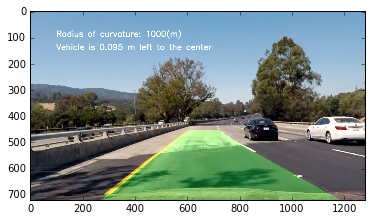

In [93]:
left_lane = Line()
right_lane = Line()
new_image= process_image(test_imgs[5])
plt.imshow(new_image)

In [67]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [94]:
clip1 = VideoFileClip("./project_video.mp4")

In [95]:
left_lane = Line()
right_lane = Line()
out_clip = clip1.fl_image(process_image)

In [96]:
output = './out_clip.mp4'
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./out_clip.mp4
[MoviePy] Writing video ./out_clip.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:41<00:00, 12.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_clip.mp4 

Wall time: 1min 42s


In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))